# Question 1.2 

In [1]:
# Import Necessary Packages 
import pathlib
import timeit
import cv2
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn import svm 
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier


Bad key "text.kerning_factor" on line 4 in
/home/somesh/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
class ChestDiseaseClassificationML(object):
    """ Class For Chest Image Classification using Machine Learning Algorithms
    Parameter: 
    -----------
    Normal_TrainImage_path: Path of Train folder for Normal Chest Images 
    Pneumonia_TrainImage_path: Path of Train folder for Pneumonia Chest Images 
    TB_TrainImage_path: Path of Train folder for TB Chest Images 

    Attributes: 
    ------------
    self 
    """

    def __init__(self, Normal_TrainImage_path, Pneumonia_TrainImage_path,
                 TB_TrainImage_path, TestImage_path, epochs = 10, batch_size = 16):

        self.epochs = epochs 
        self.batch_size = batch_size 
        self.Normal_TrainImage_path = Normal_TrainImage_path
        self.Pneumonia_TrainImage_path = Pneumonia_TrainImage_path
        self.TB_TrainImage_path = TB_TrainImage_path
        self.TestImage_path = TestImage_path

        self.train_data = []
        self.train_labels = []
   
    def Convert_Preprocess_train(self, path, label):
        """ Convert the dataset in the required Format 
        Parameter: 
        -----------
        path: Path with all images 
        label: Labes/Target Requried for the Image   

        Attributes:
        ------------
        self.train_data: Processed Train Data 
        self.train_labels: Processed Train Labels as per images in the Train dataset
        """
        for image in path:

            image = cv2.imread(str(image))  
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32)/255.
            self.train_data.append(image)
            self.train_labels.append(label)
    
        return self.train_data, self.train_labels 

    def Convert_Preprocess_test(self, path):
        """ Convert the dataset in the required Format 
        Parameters: 
        ------------
        path: Path for the Test Dataset 

        Attributes: 
        ------------
        data_list: list of Test dataset 
        """
        data_list = []

        for image in path:

            image = cv2.imread(str(image))  
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.astype(np.float32)/255.
            data_list.append(image)
    
        return data_list 

    def Load_Data(self):
        """ Load Data function for Machine Learning Approach 
        Parameter: 
        -----------
        self

        Attributes: 
        ------------
        train_data_ml: Train Data reshaped for Machine Learning Algorithms
        test_data_ml: Test Data reshaped for Machine Learning Algorithms
        train_labels_arr: Labels/Target of Train set 
        """

        # Load Normal Train Dataset into the Train data list
        Normal_TrainDir_path = pathlib.Path(self.Normal_TrainImage_path)
        normal_image_path = Normal_TrainDir_path.glob('*.jpg')
        label_normal = 0 
        normal_data, normal_labels = self.Convert_Preprocess_train(normal_image_path, label_normal)


        # Pneumonia Train Data 
        Pneumonia_TrainDir_path = pathlib.Path(self.Pneumonia_TrainImage_path)
        pneumonia_image_path = Pneumonia_TrainDir_path.glob('*.jpg')
        label_pneumonia = 1 
        pneumonia_data, pneumonia_labels = self.Convert_Preprocess_train(pneumonia_image_path, label_pneumonia)


        # TB Train Data 
        TB_TrainDir_path = pathlib.Path(self.TB_TrainImage_path)
        tb_image_path = TB_TrainDir_path.glob('*.jpg')
        label_tb = 2 
        tb_data, tb_labels = self.Convert_Preprocess_train(tb_image_path, label_tb)


        # Test Data 
        TestDir_path = pathlib.Path(self.TestImage_path)
        test_path = TestDir_path.glob('*.jpg')
        label_normal = 0 
        test_data = self.Convert_Preprocess_test(test_path)

        # Convert list to Numpy array 
        train_data_arr = np.array(self.train_data)
        train_labels_arr = np.array(self.train_labels)
        test_data_arr = np.array(test_data)

        # Reshape the dataset for Machine Learning Algorithms 
        train_data_ml = train_data_arr.reshape((251, -1))
        test_data_ml = test_data_arr.reshape((66, -1))

        return train_data_ml, test_data_ml, train_labels_arr 


    def RoC_Curve(self, classifier, X_val, y_val, title): 
        """ RoC Curve for Classifier 
        Parameters: 
        ------------
        classifier: Machine Learning Classifier to be Evaluated
        X_val: Validation Dataset
        y_val: Label/Target of Validation Dataset

        Attributes:
        Plots the Graph    
        
        Note: Some part of this Method code is taken 
            from Sklearn Website
        """

        lw = 2
        n_classes = 3
        y_test1 = to_categorical(y_val)
        pred_RFC_proba = classifier.predict_proba(X_val)
        y_score = pred_RFC_proba

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(20,10))
        plt.plot(fpr["micro"], tpr["micro"],
                label='micro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["micro"]),
                color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                label='macro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["macro"]),
                color='navy', linestyle=':', linewidth=4)

        list_class = ['Normal', 'Pneumonia', 'TB']
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=lw,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                    ''.format(list_class[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title) 
        plt.legend(loc="lower right")
        plt.show()



In [3]:
# Path of Image Folder for Train and Test Data
Normal_Train_imagedir = 'Dataset/train/Normal'  
Pneumonia_Train_imagedir = 'Dataset/train/Pneumonia'  
TB_Train_imagedir = 'Dataset/train/TB' 
Test_imagedir = 'Dataset/test'   


In [4]:
# Initialize the Machine Learning Class
ml_cl = ChestDiseaseClassificationML(Normal_Train_imagedir,Pneumonia_Train_imagedir, TB_Train_imagedir, Test_imagedir)


In [5]:
# Load the Dataset 
data_train_ml, data_test_ml, train_labels_ml = ml_cl.Load_Data()

In [6]:
# Check the Train and Test Dataset
print("Shape of Train Set: ", data_train_ml.shape)
print("Shape of Target/Label of Train set: ", train_labels_ml.shape)
print("Shape of Test Set: ", data_test_ml.shape)

Shape of Train Set:  (251, 150528)
Shape of Target/Label of Train set:  (251,)
Shape of Test Set:  (66, 150528)


In [7]:
# Split the Dataset in 70:20 ratio 
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(data_train_ml, train_labels_ml, test_size = 0.30, random_state = 42)

In [8]:
# Check the Train and Test Dataset
print("Shape of X_train Set: ", X_train_ml.shape)
print("Shape of y_train set: ", y_train_ml.shape)
print("Shape of X_val Set: ", X_val_ml.shape)
print("Shape of y_val Set: ", y_val_ml.shape)

Shape of X_train Set:  (175, 150528)
Shape of y_train set:  (175,)
Shape of X_val Set:  (76, 150528)
Shape of y_val Set:  (76,)


## 1.1 SVM Classifier 

In [9]:
# Initialize the SVM Classifier 
svm_clf = svm.SVC(gamma = 'auto', kernel = 'linear', decision_function_shape = 'ovo', probability = True)

In [10]:
# Train the model 
start = timeit.default_timer()
svm_clf.fit(X_train_ml, y_train_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Training Time for SVM on the Training Set is {0} Seconds".format(stop - start))
sys.stderr.flush()


 Training Time for SVM on the Training Set is 22.354527491000226 Seconds

In [11]:
# Predict on the Validation Set 
start = timeit.default_timer()
y_val_pred_svm = svm_clf.predict(X_val_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Prediction Time for SVM on Validation Set is {0} Seconds".format(stop - start))
sys.stderr.flush()


 Prediction Time for SVM on Validation Set is 2.0760269390002577 Seconds

In [12]:
# Accuracy Score on Validation Set 
print("Accuracy Score for SVM on Validation set: {0:.3f}%".format(accuracy_score(y_val_ml, y_val_pred_svm)* 100))

Accuracy Score for SVM on Validation set: 94.737%


#### Note: 
1. with gamma = 'auto', kernel = 'rbf', decision_function_shape = 'ovo', probability = True accuracy is 89.474%
2. with gamma = 'scale', kernel = 'rbf', decision_function_shape = 'ovo', probability = True accuracy is 93.421%
3. with gamma = 'scale', kernel = 'linear', decision_function_shape = 'ovo', probability = True accuracy is 94.737%
4. with gamma = 'auto', kernel = 'linear', decision_function_shape = 'ovo', probability = True accuracy is 94.737%
5. with gamma = 'auto', kernel = 'poly', decision_function_shape = 'ovo', probability = True accuracy is 44.737%
6. with gamma = 'scale', kernel = 'poly', decision_function_shape = 'ovo', probability = True accuracy is 94.737%
7. with gamma = 'auto', kernel = 'sigmoid', decision_function_shape = 'ovo', probability = True accuracy is 77.632%
8. with gamma = 'scale', kernel = 'sigmoid', decision_function_shape = 'ovo', probability = True accuracy is 44.737%

In [13]:
# Classification Report for SVM on Validation Report 
print("Classification Report for SVM on Validation Set: \n", classification_report(y_val_ml, y_val_pred_svm))

Classification Report for SVM on Validation Set: 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.92      0.96      0.94        23
           2       1.00      0.97      0.99        34

    accuracy                           0.95        76
   macro avg       0.94      0.94      0.94        76
weighted avg       0.95      0.95      0.95        76



In [14]:
# Predict the Labels for Test Set using SVM Classifier 
start = timeit.default_timer()
y_pred_test = svm_clf.predict(data_test_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Prediction Time for SVM on Test Set is {0} Seconds".format(stop - start))
sys.stderr.flush()


 Prediction Time for SVM on Test Set is 1.7156427540003278 Seconds

In [15]:
# Predicted Test set 
print("Predicted Test Labels using SVM Classifier: \n", y_pred_test) 

Predicted Test Labels using SVM Classifier: 
 [0 2 1 1 1 0 1 2 2 0 2 1 1 2 2 0 0 2 2 2 2 2 1 1 1 0 2 2 0 0 0 1 1 0 0 2 1
 1 2 2 2 2 1 1 0 2 2 2 1 1 1 0 0 0 1 0 2 0 0 0 1 2 1 1 0 2]


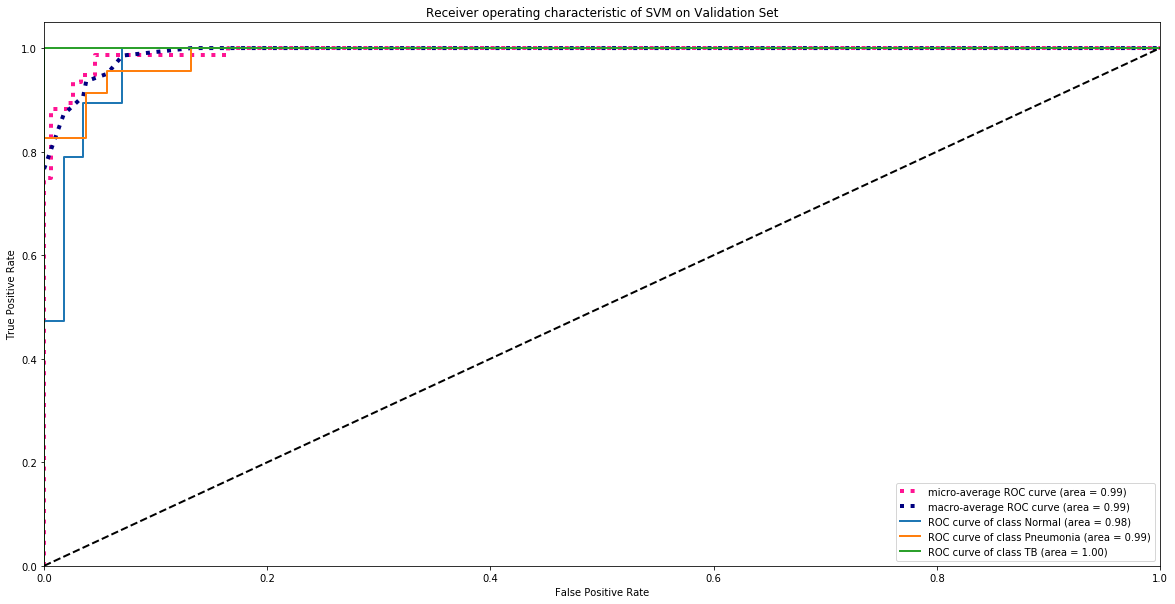

In [16]:
# Roc Curve for SVM Classifier 
title = 'Receiver operating characteristic of SVM on Validation Set'
ml_cl.RoC_Curve(svm_clf, X_val_ml, y_val_ml, title)

## 1.2 Random Forest 


In [17]:
# Initialize the Random Forest Classifier 
rf = RandomForestClassifier(criterion = "entropy",  bootstrap = True, random_state= 42, n_jobs = -1)

In [18]:
# Train the Classifier 
start = timeit.default_timer()
rf.fit(X_train_ml, y_train_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Training Time for Random Forest on Train Set is {0} Seconds".format(stop - start))
sys.stderr.flush()


 Training Time for Random Forest on Train Set is 3.2468145319999167 Seconds

In [19]:
# Predict on the Validation set
start = timeit.default_timer() 
y_pred_val_rf = rf.predict(X_val_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Prediction Time for Random Forest on Validation Set is {0} Seconds".format(stop - start))
sys.stderr.flush()



 Prediction Time for Random Forest on Validation Set is 0.2126626170002055 Seconds

In [20]:
# Accuracy Score for Random Forest 
rf_acc_score = accuracy_score(y_val_ml, y_pred_val_rf)
print("Accuracy Score for Random Forest on Validatoin Set: {0:.3f}%".format(rf_acc_score * 100))

Accuracy Score for Random Forest on Validatoin Set: 92.105%


#### Note: 
1. With criterion = "entropy", max_depth= None, bootstrap = True, random_state= 42, n_jobs = -1 the accuracy score is 92.105% because changing max_depth has no effect. 
2. With criterion = "gini", max_depth= None, bootstrap = True, random_state= 42, n_jobs = -1 the accuracy score is 90.789%


In [21]:
# Classification Report for Random Forest 
print("Classification Report for Random Forest on Validation Set: \n", classification_report(y_val_ml, y_pred_val_rf))

Classification Report for Random Forest on Validation Set: 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.87      0.87      0.87        23
           2       1.00      1.00      1.00        34

    accuracy                           0.92        76
   macro avg       0.90      0.90      0.90        76
weighted avg       0.92      0.92      0.92        76



In [22]:
# Predited Labels/Target for the Test Set
start = timeit.default_timer()  
y_pred_test_rf = rf.predict(data_test_ml)
stop = timeit.default_timer()
sys.stderr.write(" \n Prediction Time for Random Forest on Test Set is {0} Seconds".format(stop - start))
sys.stderr.flush()


 Prediction Time for Random Forest on Test Set is 0.11294496099981188 Seconds

In [23]:
# Predicted Labels on the Test Set 
print("Predicted Target/Labels for Test Set using Random Forest: \n", y_pred_test_rf) 

Predicted Target/Labels for Test Set using Random Forest: 
 [0 2 1 1 1 0 1 2 2 1 2 1 1 2 2 0 1 2 1 2 2 2 1 1 1 0 2 2 0 2 0 1 1 0 1 2 1
 1 2 2 2 2 1 1 1 2 2 2 0 0 1 0 0 1 0 0 2 0 1 1 1 2 1 1 1 2]


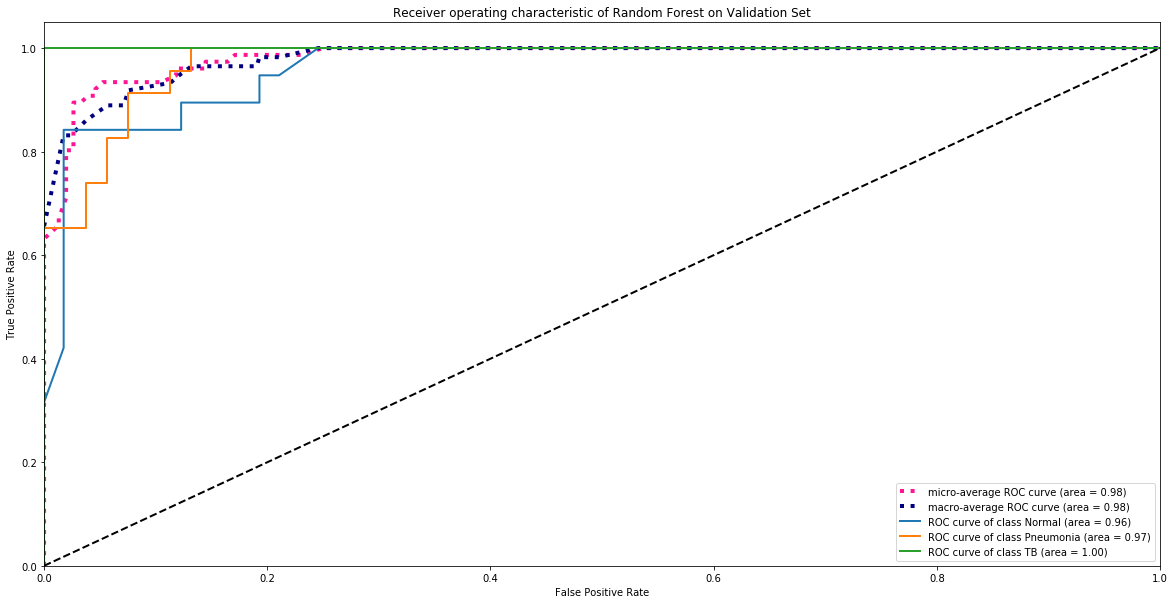

In [24]:
# RoC Curve Plot for Random Forest 
title = 'Receiver operating characteristic of Random Forest on Validation Set'
ml_cl.RoC_Curve(rf, X_val_ml, y_val_ml, title)